# <font color ='blue'>Zillow Clustering Project - Working Copy
    
<img src="zillow_logo.png" alt="Zillow Logo" title="Zillow Logo" width="300" height="100" align="right"/>
    
    
# <p style="font-size:50px" align="center">Zestimate Error</p> <sub>By Kaniela Denis - 13 Dec 2021</sub>

In [1]:
# import pandas and numpy to start coding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# prep methods
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler

# cluster method
from sklearn.cluster import KMeans

# Feature Engineering methods
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# Modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid blue"> </hr>

# <font color = 'red'>Planning

### Project Goals

- Predict logerror of Zestimate
- Discover the drivers of the error in the Zcestimate
- Compare four different clustering models
- Conclude if clustering helps with discovering drivers
- 


- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each county.


### Project Description

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebook
    - Modules (Acquire, Prepare, Model)
    - Misc Artifacts
2. Further Requirements:
    - Aquistion:
        - SQL Query
    - Prep:
        - Columns have appropriate Data Types
        - Missing values and Outliers are investigated/handled
    - Explore:
        - Use vizulization and statistical testing for target/independ variable interations
        - Clustering is used to explore the data. Minumum of 3 combinations of features tried. A conclusion is made on whether clustering helped, supported by visualizations and statistical testing.
    - Modeling: 
        - Minimum 4 different models created and performance compared
3. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
4. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

### Data Dictionary (Add to README)

In [2]:
# Read Data Dictionary from working directory
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


In [3]:
## References are available on my GitHub 

In [4]:
#[click me](https://github.com/kanieladenis/zillow_regression_project)

# <font color = 'red'> Acquisition (Get and Clean Data)

## <font color = 'red'>Get Data

- Added env.py to the repo .gitignore file so env.py won't be pushed to github
- Created an env file that contains my username, password, and host address fo the MySQL Server.

In [5]:
# import env file for hostname, username, password, and db_name
from env import host, user, password, db_name

In [6]:
# Pass env file authentication to container 'url'
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

### Pull records of houses with transactions from 2017

In [7]:
# define sql search for all records from all tables
sql = """
SELECT prop.*,
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
JOIN (SELECT parcelid,
                  logerror,
                  Max(transactiondate) transactiondate 
           FROM   predictions_2017 
           GROUP  BY parcelid, logerror) pred
       USING (parcelid)
JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
LEFT JOIN storytype story USING (storytypeid) 
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
AND prop.longitude IS NOT NULL
AND transactiondate < '2018-01-01' 
AND propertylandusetypeid = 261 
"""

### Note:
- ????

### Create Dataframe

In [8]:
# load zillow data from saved csv or pull from sql server and save to csv
import os
file = 'zillow_data_kan.csv'
if os.path.isfile(file):
    df = pd.read_csv(file, index_col=0)
else:
    df = pd.read_sql(sql,url)
    df.to_csv(file)
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,...,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


### Show df info()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52438 entries, 0 to 52437
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52438 non-null  int64  
 1   parcelid                      52438 non-null  int64  
 2   airconditioningtypeid         13638 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52438 non-null  float64
 6   bedroomcnt                    52438 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33739 non-null  float64
 9   calculatedbathnbr             52301 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4379 non-null   float64
 12  calculatedfinishedsquarefeet  52356 non-null  float64
 13  f

In [10]:
# df shape
df.shape

(52438, 68)

In [11]:
# Show duplicated observations even with SQL filter
df.parcelid.duplicated().sum()

118

In [12]:
# Sort df by parcelid and then by transaction date to group by parcelid and to make sure transaction date is last
df = df.sort_values(by=['parcelid','transactiondate'])
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
37223,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
48246,1072280,10711877,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
15536,1340933,10711888,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
12106,1878109,10711910,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
13666,2190858,10711923,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [13]:
# Show duplicated parcel id
df[df.duplicated(subset='parcelid', keep=False)].head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
9384,16179,10722858,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6.037135e+13,0.095171,2017-03-02,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
9385,16179,10722858,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6.037135e+13,-0.172843,2017-07-28,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
9306,1836115,10732347,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037137e+13,0.077198,2017-03-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
9307,1836115,10732347,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037137e+13,-0.221145,2017-07-25,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1940,2119208,10739478,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037800e+13,0.083280,2017-01-13,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [14]:
# drop dulicates  but keep last transaction date
df = df.drop_duplicates(subset='parcelid', keep='last')

In [15]:
# Show duplicated parcel id
df[df.duplicated(subset='parcelid', keep=False)].head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc


In [16]:
# confirm duplicated parcel id removed
df.parcelid.duplicated().sum()

0

In [17]:
# check new shape
df.shape

(52320, 68)

In [18]:
# Replace blank values with NaN
df = df.replace('',np.nan)

In [19]:
# check if long/lat columns have nulls
df.longitude.isnull().sum(), df.latitude.isnull().sum()

(0, 0)

In [20]:
# number of nulls per column
df.isna().sum()

id                              0
parcelid                        0
airconditioningtypeid       38705
architecturalstyletypeid    52250
basementsqft                52273
                            ...  
buildingclassdesc           52320
heatingorsystemdesc         18470
propertylandusedesc             0
storydesc                   52273
typeconstructiondesc        52244
Length: 68, dtype: int64

In [21]:
# percent of nulls per column
df.isna().mean()

id                          0.000000
parcelid                    0.000000
airconditioningtypeid       0.739774
architecturalstyletypeid    0.998662
basementsqft                0.999102
                              ...   
buildingclassdesc           1.000000
heatingorsystemdesc         0.353020
propertylandusedesc         0.000000
storydesc                   0.999102
typeconstructiondesc        0.998547
Length: 68, dtype: float64

In [22]:
# number of nulls per row
df.isna().sum(axis=1)

37223    31
48246    29
15536    31
12106    31
13666    31
         ..
42306    35
31148    36
23911    36
9001     48
28113    48
Length: 52320, dtype: int64

In [23]:
# number of rows with a specific number of nulls
df.isna().sum(axis=1).value_counts()

33    11967
34    11158
32     8885
31     5989
36     4138
35     3469
29     2527
30     2199
37     1020
28      390
38      223
27      177
44       46
26       30
39       29
40       15
24       12
25       11
43       10
42        7
45        6
41        6
23        2
48        2
46        1
47        1
dtype: int64

In [24]:
# create dataframe that has column name as first column
col_nulls = pd.DataFrame()
col_nulls['columns_name'] = df.isna().sum().index
col_nulls

,columns_name
0,id
1,parcelid
2,airconditioningtypeid
3,architecturalstyletypeid
4,basementsqft
...,...
63,buildingclassdesc
64,heatingorsystemdesc
65,propertylandusedesc
66,storydesc


In [25]:
# create new column that hold the sum of nulls from each column
col_nulls['row_null_count'] = df.isna().sum().values
col_nulls

,columns_name,row_null_count
0,id,0
1,parcelid,0
2,airconditioningtypeid,38705
3,architecturalstyletypeid,52250
4,basementsqft,52273
...,...,...
63,buildingclassdesc,52320
64,heatingorsystemdesc,18470
65,propertylandusedesc,0
66,storydesc,52273


In [26]:
# create new column that hold the average of nulls from each column
col_nulls['row_null_percent'] = df.isna().mean().values
col_nulls

,columns_name,row_null_count,row_null_percent
0,id,0,0.000000
1,parcelid,0,0.000000
2,airconditioningtypeid,38705,0.739774
3,architecturalstyletypeid,52250,0.998662
4,basementsqft,52273,0.999102
...,...,...,...
63,buildingclassdesc,52320,1.000000
64,heatingorsystemdesc,18470,0.353020
65,propertylandusedesc,0,0.000000
66,storydesc,52273,0.999102


In [27]:
# sort values by percent
col_nulls = col_nulls.sort_values(by=['row_null_percent'], ascending=False)
col_nulls

,columns_name,row_null_count,row_null_percent
63,buildingclassdesc,52320,1.000000
7,buildingclasstypeid,52320,1.000000
15,finishedsquarefeet15,52320,1.000000
14,finishedsquarefeet13,52320,1.000000
42,storytypeid,52273,0.999102
...,...,...,...
25,latitude,0,0.000000
18,fips,0,0.000000
6,bedroomcnt,0,0.000000
5,bathroomcnt,0,0.000000


In [28]:
# shows column nulls in each row
row_nulls = pd.DataFrame(df.isnull().sum(axis=1), columns=['row_nulls'])
row_nulls.head()

,row_nulls
37223,31
48246,29
15536,31
12106,31
13666,31


In [29]:
# shows index as id
row_nulls = row_nulls.reset_index()
row_nulls.head()

,index,row_nulls
0,37223,31
1,48246,29
2,15536,31
3,12106,31
4,13666,31


In [30]:
# Create df with number of rows with a specific number of null columns
row_nulls = pd.DataFrame(df.isna().sum(axis=1).value_counts(), columns=['num_rows_with_n_null_cols'])
row_nulls.head()

,num_rows_with_n_null_cols
33,11967
34,11158
32,8885
31,5989
36,4138


In [31]:
# make first columnb the number of nulls
row_nulls = row_nulls.reset_index()
row_nulls.head()

,index,num_rows_with_n_null_cols
0,33,11967
1,34,11158
2,32,8885
3,31,5989
4,36,4138


In [32]:
# rename index to match values
row_nulls = row_nulls.rename(columns={'index':'n_null_cols'})
row_nulls.head()

,n_null_cols,num_rows_with_n_null_cols
0,33,11967
1,34,11158
2,32,8885
3,31,5989
4,36,4138


In [33]:
# create columsn for percent of null cols
row_nulls['percent_null_cols'] = row_nulls.n_null_cols / df.shape[1]
row_nulls.head()

,n_null_cols,num_rows_with_n_null_cols,percent_null_cols
0,33,11967,0.485294
1,34,11158,0.500000
2,32,8885,0.470588
3,31,5989,0.455882
4,36,4138,0.529412


In [34]:
# sort df by percentn of null cols
row_nulls = row_nulls.sort_values(by=['percent_null_cols'], ascending=False)
row_nulls

,n_null_cols,num_rows_with_n_null_cols,percent_null_cols
23,48,2,0.705882
25,47,1,0.691176
24,46,1,0.676471
20,45,6,0.661765
12,44,46,0.647059
18,43,10,0.632353
19,42,7,0.617647
21,41,6,0.602941
15,40,15,0.588235
14,39,29,0.573529


# Prepare

In [35]:
# show value counts for each column, does not include nulls
for col in df.columns:
    print(f'-------------{col}-----------------')
    print(df[df[col].notna()][col].value_counts(dropna=False))

-------------id-----------------
2232322    1
2324100    1
151139     1
949861     1
2538363    1
          ..
738319     1
115949     1
1692911    1
2960624    1
657407     1
Name: id, Length: 52320, dtype: int64
-------------parcelid-----------------
10913809    1
14004381    1
12888190    1
14243968    1
11227265    1
           ..
14147054    1
13096431    1
12660208    1
12789233    1
12853244    1
Name: parcelid, Length: 52320, dtype: int64
-------------airconditioningtypeid-----------------
1.0     11873
13.0     1567
5.0       159
11.0       16
Name: airconditioningtypeid, dtype: int64
-------------architecturalstyletypeid-----------------
7.0     62
3.0      3
2.0      2
21.0     2
8.0      1
Name: architecturalstyletypeid, dtype: int64
-------------basementsqft-----------------
273.0     2
515.0     2
100.0     2
900.0     2
912.0     2
640.0     2
352.0     1
90.0      1
300.0     1
588.0     1
1252.0    1
280.0     1
384.0     1
3560.0    1
396.0     1
1969.0    1
252.0    

Central      11873
Yes           1567
None           159
Wall Unit       16
Name: airconditioningdesc, dtype: int64
-------------architecturalstyledesc-----------------
Contemporary     62
Cape Cod          3
Bungalow          2
Ranch/Rambler     2
Conventional      1
Name: architecturalstyledesc, dtype: int64
-------------buildingclassdesc-----------------
Series([], Name: buildingclassdesc, dtype: int64)
-------------heatingorsystemdesc-----------------
Central       20689
Floor/Wall    12527
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64
-------------propertylandusedesc-----------------
Single Family Residential    52320
Name: propertylandusedesc, dtype: int64
-------------storydesc-----------------
Basement    47
Name: storydesc, dtype: int64
-------------typeconstructiondesc-----------------
Frame       75
Concrete     1
Name: typeconstructiondesc, d

In [36]:
# remove propeties that have no bedrooms and no bathrooms and too small of an area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & (df.unitcnt <= 1) | df.unitcnt.isna() & (df.calculatedfinishedsquarefeet > 500) & (df.bedroomcnt > 0) & (df.bathroomcnt > 0)]

In [37]:
df.shape

(52115, 68)

In [38]:
# set threshhold for number of non-null rows in each column to determine drop
thresh_col = .5 * df.shape[0]
thresh_col

26057.5

In [39]:
# drop columns that meet null-rows threshhold
df = df.dropna(axis=1, thresh=thresh_col)
df.shape

(52115, 34)

In [40]:
# set threshhold for number of non-null columns each row must to determine drop
thresh_row = .7 * df.shape[1]
thresh_row

23.799999999999997

In [41]:
df = df.dropna(axis=0, thresh=thresh_row)
df.shape

(52115, 34)

In [42]:
def handle_missing_values(df, percent_required_cols = .5, percent_required_rows = .7):
    
    # set threshold for min of values in columns for dropping
    thresh_col = int(round(percent_required_cols * df.shape[0]))
    
    # drop columns that don't meed threshhold for non-null values (rows without nulls)
    df = df.dropna(axis=1, thresh=thresh_col)
    
    # set threshold for min non-null values for rows (cols without nulls)
    thresh_row = int(round(percent_required_rows * df.shape[1]))
    
    # drop rows with don't meet threshold for non-null values for columns
    df = df.dropna(axis=0, thresh=thresh_row)
    
    return df, thresh_col, thresh_row,

In [43]:
# Run fucntion to remove columns and rows that meet thresh hold
df, thresh_col, thresh_row  = handle_missing_values(df, percent_required_cols = .5, percent_required_rows = .5)

In [44]:
# see new df shape, 
df.shape, thresh_col, thresh_row

((52115, 34), 26058, 17)

### Deal with the rest of the nulls

In [45]:
df.isna().sum()

id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18510
calculatedbathnbr                  15
calculatedfinishedsquarefeet        0
finishedsquarefeet12              153
fips                                0
fullbathcnt                        15
heatingorsystemtypeid           18307
latitude                            0
longitude                           0
lotsizesquarefeet                 350
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              18449
rawcensustractandblock              0
regionidcity                     1028
regionidcounty                      0
regionidzip                        23
roomcnt                             0
unitcnt                         18424
yearbuilt                          33
structuretaxvaluedollarcnt         69
taxvaluedollarcnt                   1
assessmentye

### Dropping Unneeded Columns:
- parcel id, id, popertylandusetype, unitcnt: no longer needed after data filtering
- propertyzoningdesc, finishedsquarefeet12, censustracdtandblock, rawcensustracdtandblock, heatingorsystemtupeid, assessmentyear, transactiondate: Not useful

In [46]:
# remove columns that are not useful
df = df.drop(columns=[
    # uniquie identifer to lot
    'parcelid',
    # uniquie identifer for table        
    'id',
     #Description of the allowed land uses (zoning) for that property
     'propertyzoningdesc', 
     # Finished living area
     'finishedsquarefeet12',
     #  Census tract and block ID combined - also contains blockgroup assignment by extension
         'censustractandblock',
      # Type of land use the property is zoned for
      'propertylandusetypeid',
      #  Type of home heating system
      'heatingorsystemtypeid',
    # unit type cnt: filtered out to only 1 cnt, no longer needed
    'unitcnt',
    # Census tract and block ID combined, not needed
    'rawcensustractandblock',
    # year assessed
    'assessmentyear',
    # date of transaction
    'transactiondate',
    #  Number of bathrooms in home including fractional bathroom. duplicate from bathroomcnt
    'calculatedbathnbr',
    #  Total number of rooms in the principal residence. Not collected for LA County
    'roomcnt',
    # descirpiton of land use (single family), no longer needed
    'propertylandusedesc'
    
    ])

In [47]:
df.shape

(52115, 20)

In [48]:
# check value counts for heating systems
df.heatingorsystemdesc.value_counts(dropna=False)

Central       20670
NaN           18307
Floor/Wall    12504
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [49]:
# check value counts for heating sytems in LA
df[df.fips == 6037].heatingorsystemdesc.value_counts(dropna=False)

Central       20670
Floor/Wall    12475
NaN             498
Solar            85
Name: heatingorsystemdesc, dtype: int64

In [50]:
# check value counts for heating sytems in OC
df[df.fips == 6059].heatingorsystemdesc.value_counts(dropna=False)

NaN           13463
Forced air      517
Floor/Wall       29
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [51]:
# check value counts for heating sytems in Ventura
df[df.fips == 6111].heatingorsystemdesc.value_counts(dropna=False)

NaN    4346
Name: heatingorsystemdesc, dtype: int64

In [52]:
# relacing nulls with 'None', assuming null was for not having a heating system
df.heatingorsystemdesc.fillna('None', inplace=True)

In [53]:
# checking nulls were removed
df.heatingorsystemdesc.isna().sum()

0

In [54]:
# checking building quality type id for LA
df[df.fips == 6037].buildingqualitytypeid.value_counts(dropna=False)

6.0     10250
8.0      8218
4.0      8125
7.0      3419
5.0      1495
9.0      1118
11.0      514
10.0      228
3.0       147
NaN       123
12.0       80
1.0         8
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [55]:
# checking building quality type id for OC
df[df.fips == 6059].buildingqualitytypeid.value_counts(dropna=False)

NaN    14041
Name: buildingqualitytypeid, dtype: int64

In [56]:
# checking building quality type id for Vetura
df[df.fips == 6111].buildingqualitytypeid.value_counts(dropna=False)

NaN    4346
Name: buildingqualitytypeid, dtype: int64

### Looks like building quality type was not collected for OC or Ventura. Dropping column.

In [57]:
# droping buildingqualitytypeid because they are not collected for Ventura and Orange
df.drop(columns=['buildingqualitytypeid'], inplace=True)

In [58]:
df.shape

(52115, 19)

In [59]:
df.isna().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                       15
latitude                           0
longitude                          0
lotsizesquarefeet                350
propertycountylandusecode          0
regionidcity                    1028
regionidcounty                     0
regionidzip                       23
yearbuilt                         33
structuretaxvaluedollarcnt        69
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          4
logerror                           0
heatingorsystemdesc                0
dtype: int64

In [60]:
# dropping the rest of the nulls
df.dropna(inplace=True)

In [61]:
df.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
heatingorsystemdesc             0
dtype: int64

## Remove Outliers

In [62]:
# List of columns
cols = [col for col in df.columns.drop(['bedroomcnt',
                                        'fips',
                                        'propertycountylandusecode',
                                        'heatingorsystemdesc'
                                       ])]
cols

['bathroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror']

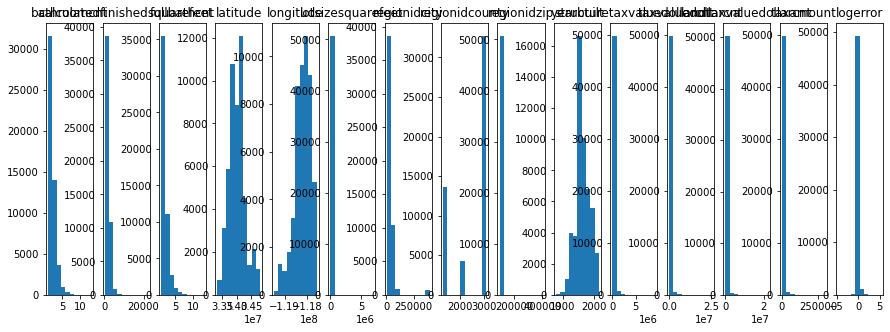

In [63]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

In [64]:
df.shape

(50677, 19)

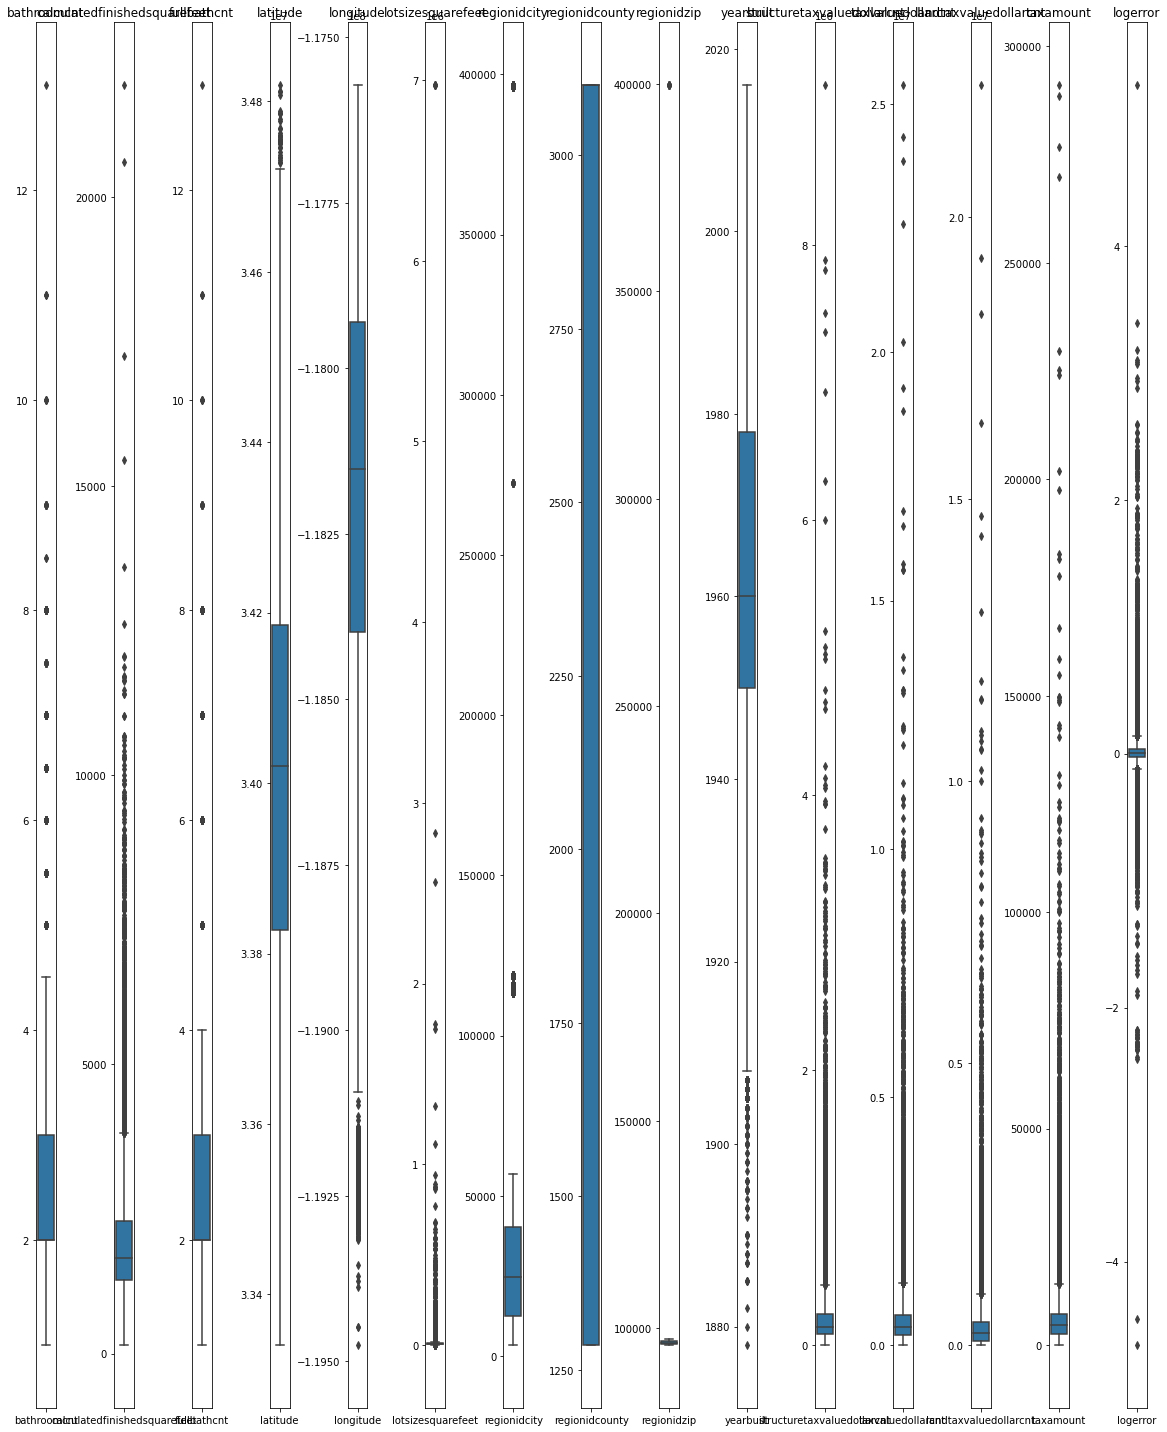

In [65]:
# List of columns
        
plt.figure(figsize=(16, 20))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)
    
    # sets proper spacing between plots
    plt.tight_layout()

plt.show()

In [66]:
# remove outliers from each column in cols_list
for col in cols:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles

    iqr = q3 - q1   # calculate interquartile range

    upper_bound = q3 + 1.5 * iqr   # get upper bound
    lower_bound = q1 - 1.5 * iqr   # get lower bound

    # return dataframe without outliers

    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

In [67]:
df.shape

(31456, 19)

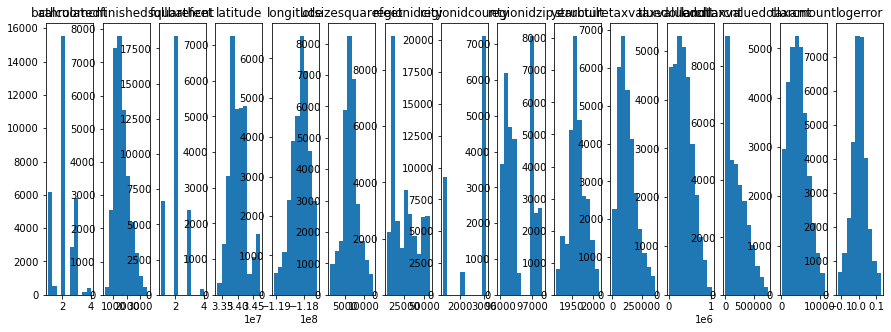

In [68]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

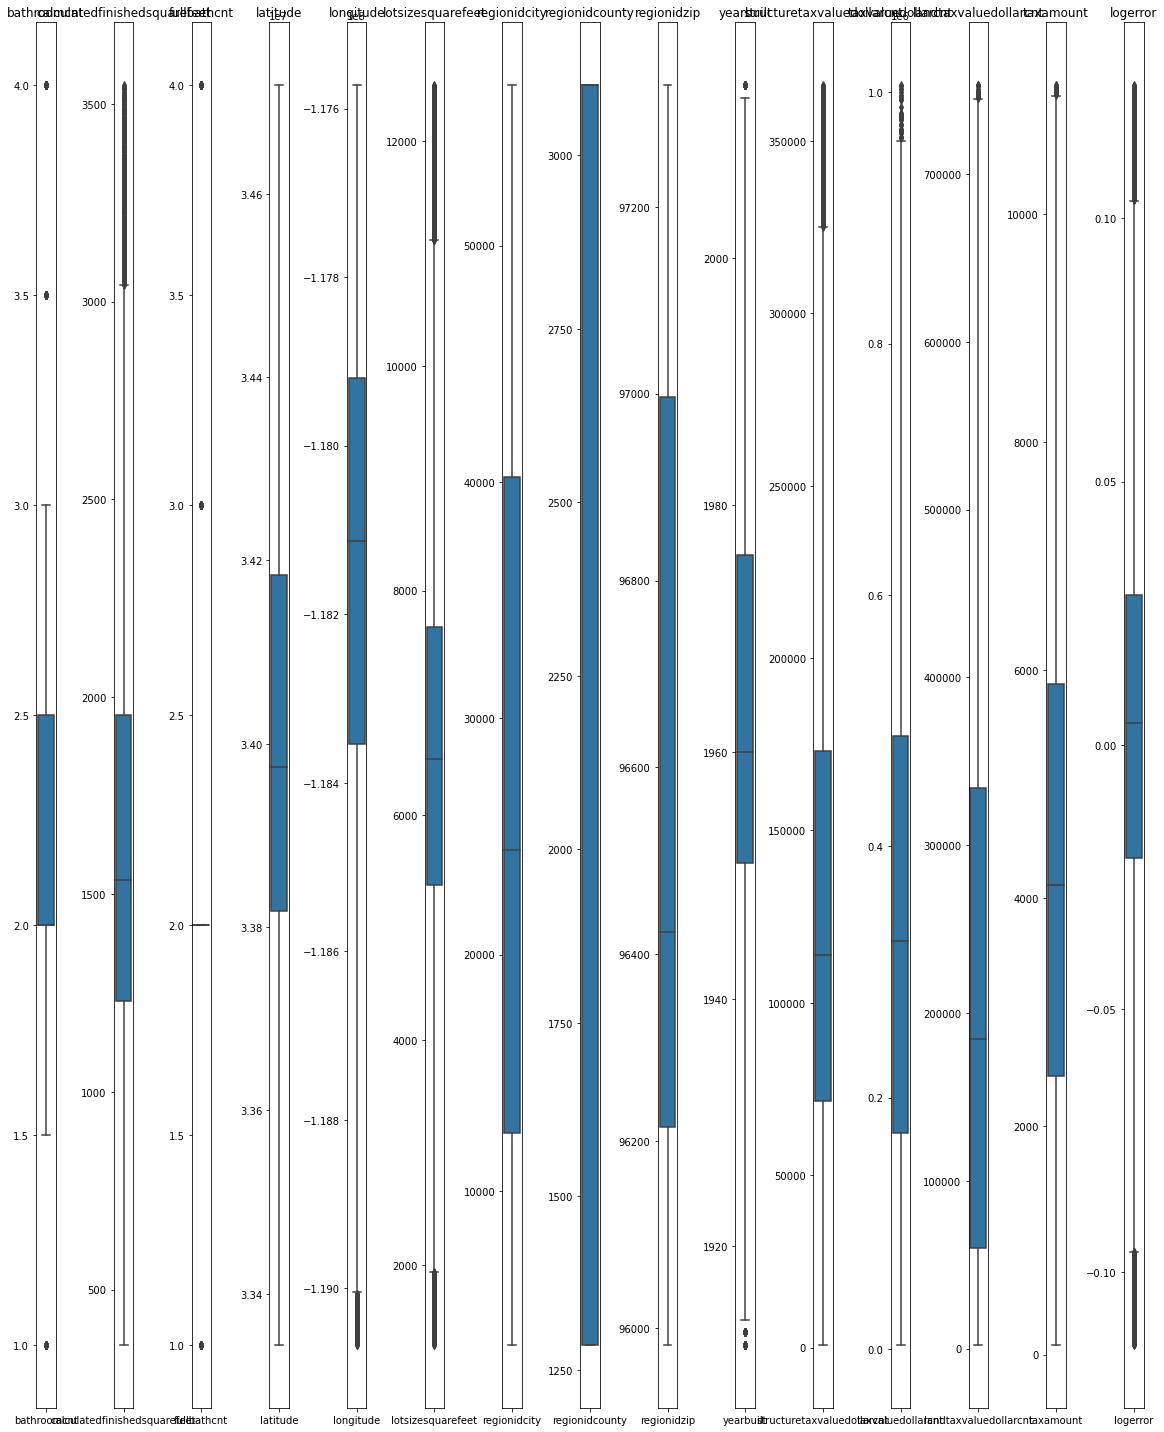

In [69]:
# List of columns
        
plt.figure(figsize=(16, 20))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)
    
    # sets proper spacing between plots
    plt.tight_layout()

plt.show()

## Rename for Readability

In [70]:
df.columns.to_list()

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'heatingorsystemdesc']

In [71]:
# rename for readability
df = df.rename(columns = {'bathroomcnt':'bathrooms',
 'bedroomcnt':'bedrooms',
 'calculatedfinishedsquarefeet':'house_area',
 'fullbathcnt':'full_baths',
 'lotsizesquarefeet':'lot_area',
 'propertycountylandusecode':'land_use_code',
 'regionidcity':'city_id',
 'regionidcounty':'county_id',
 'regionidzip':'zip_id',
 'yearbuilt':'year_built',
 'structuretaxvaluedollarcnt':'tax_value_house',
 'taxvaluedollarcnt':'tax_value_total',
 'landtaxvaluedollarcnt':'tax_value_land',
 'taxamount':'tax_amount',
 'heatingorsystemdesc':'heating_sys',
})

In [72]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys']

## Add Columns: Age, Absolute LogError, County

In [73]:
# create column for age of house
df['age'] = 2017 - df.year_built
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,county_id,zip_id,year_built,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,3101.0,96339.0,1972.0,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,3101.0,96339.0,1972.0,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,3101.0,96339.0,1972.0,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,3101.0,96339.0,1960.0,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,3101.0,96339.0,1960.0,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0


In [74]:
# Create column for absolute value of logerror
df['logerror_abs'] = df.logerror.abs()
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,zip_id,year_built,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,96339.0,1972.0,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0,0.007357
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,96339.0,1972.0,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0,0.021066
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,96339.0,1972.0,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0,0.077174
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,96339.0,1960.0,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0,0.041238
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,96339.0,1960.0,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0,0.009496


In [75]:
# create columsn to match fips to county(LA, Orange County, Ventury County)
df['county'] = df.fips.map({6037:'LA',
            6059:'OC',
            6111:'Ventura'})
df.head()

,bathrooms,bedrooms,house_area,fips,full_baths,latitude,longitude,lot_area,land_use_code,city_id,...,year_built,tax_value_house,tax_value_total,tax_value_land,tax_amount,logerror,heating_sys,age,logerror_abs,county
37223,2.0,3.0,2107.0,6037.0,2.0,34222559.0,-118617387.0,9158.0,0101,12447.0,...,1972.0,249655.0,624139.0,374484.0,7659.36,-0.007357,Central,45.0,0.007357,LA
48246,2.0,4.0,1882.0,6037.0,2.0,34220261.0,-118616409.0,9035.0,0101,12447.0,...,1972.0,253000.0,660000.0,407000.0,8123.91,0.021066,Central,45.0,0.021066,LA
15536,2.0,4.0,1882.0,6037.0,2.0,34222491.0,-118616854.0,9800.0,0100,12447.0,...,1972.0,257591.0,542923.0,285332.0,6673.24,0.077174,Central,45.0,0.077174,LA
12106,2.0,3.0,1477.0,6037.0,2.0,34221864.0,-118615739.0,11285.0,0101,12447.0,...,1960.0,57968.0,78031.0,20063.0,1116.46,-0.041238,Central,57.0,0.041238,LA
13666,2.0,4.0,1918.0,6037.0,2.0,34220619.0,-118615253.0,11239.0,0101,12447.0,...,1960.0,167869.0,415459.0,247590.0,5239.85,-0.009496,Central,57.0,0.009496,LA


In [76]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys',
 'age',
 'logerror_abs',
 'county']

## Split

In [78]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
train.shape, validate.shape, test.shape

((17614, 22), (7550, 22), (6292, 22))

## Explore

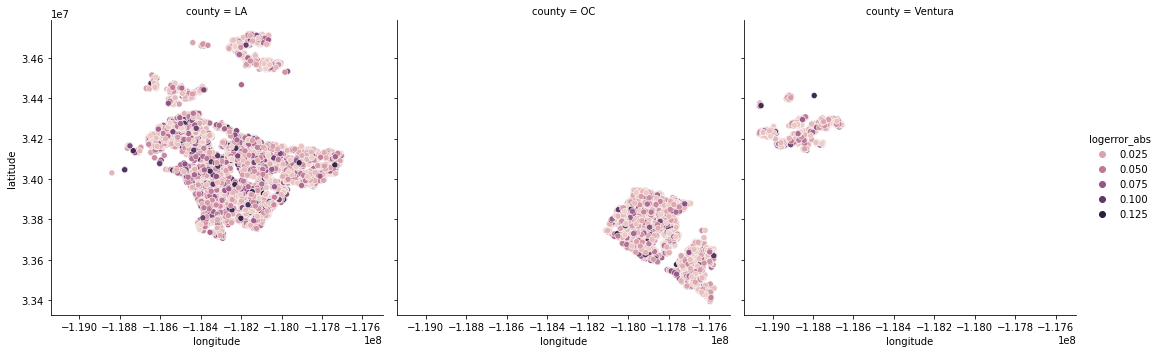

In [83]:
sns.relplot(data=train, x='longitude', y='latitude', hue='logerror_abs', col='county', kind='scatter')

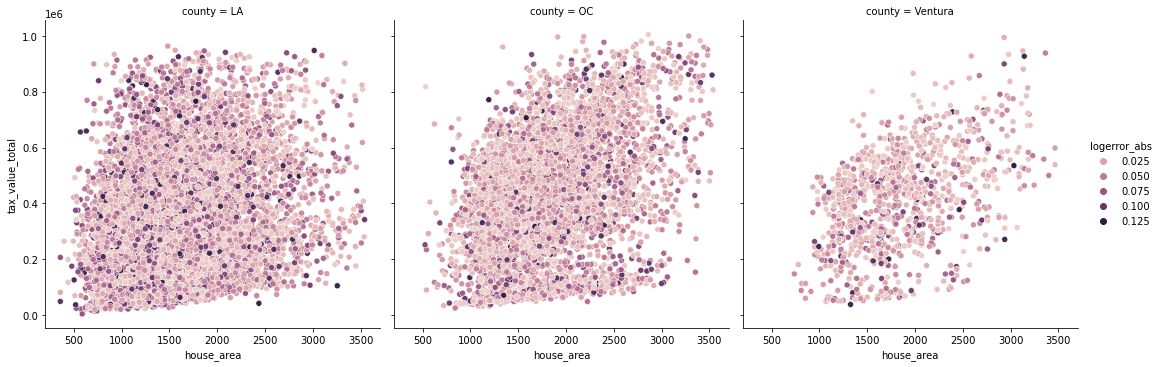

In [82]:
sns.relplot(data=train, x='house_area', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

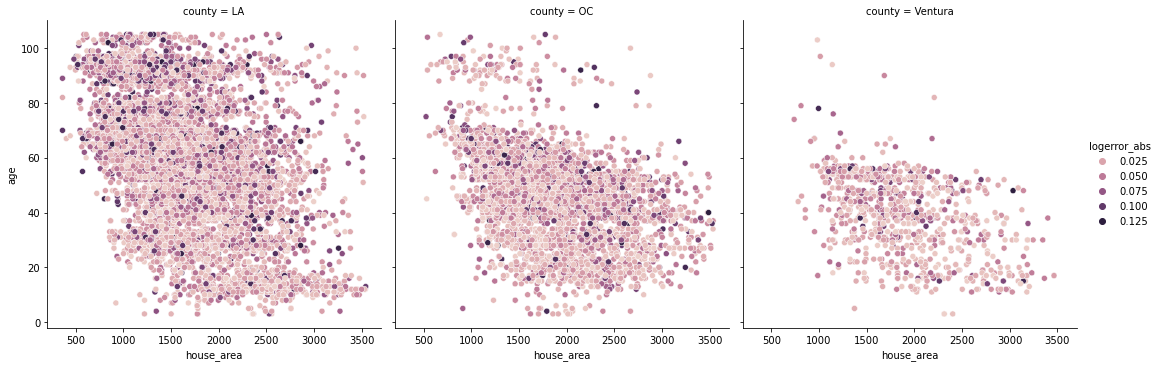

In [85]:
sns.relplot(data=X_train, x='house_area', y='age', hue='logerror_abs', col='county', kind='scatter')

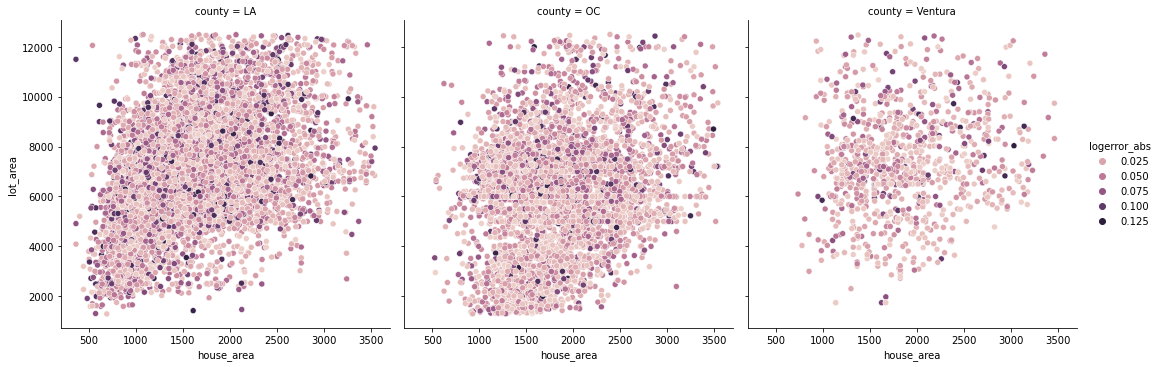

In [88]:
sns.relplot(data=X_train, x='house_area', y='lot_area', hue='logerror_abs', col='county', kind='scatter')

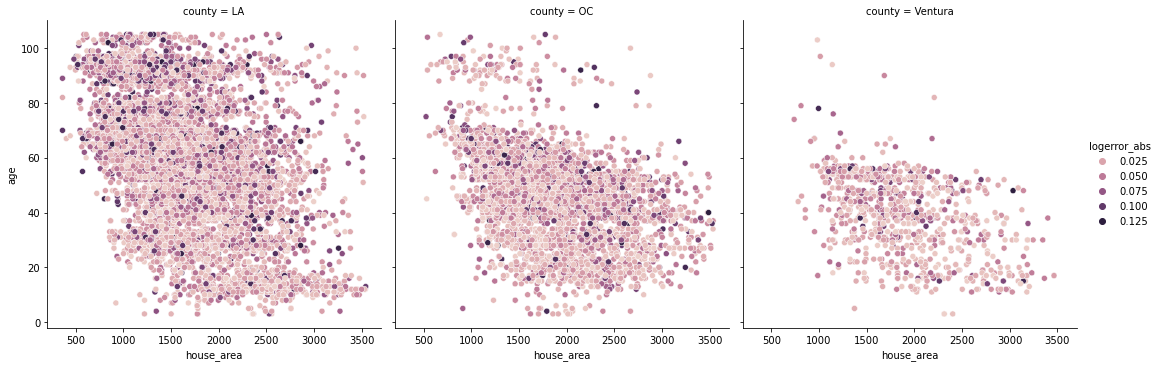

In [84]:
sns.relplot(data=X_train, x='house_area', y='age', hue='logerror_abs', col='county', kind='scatter')

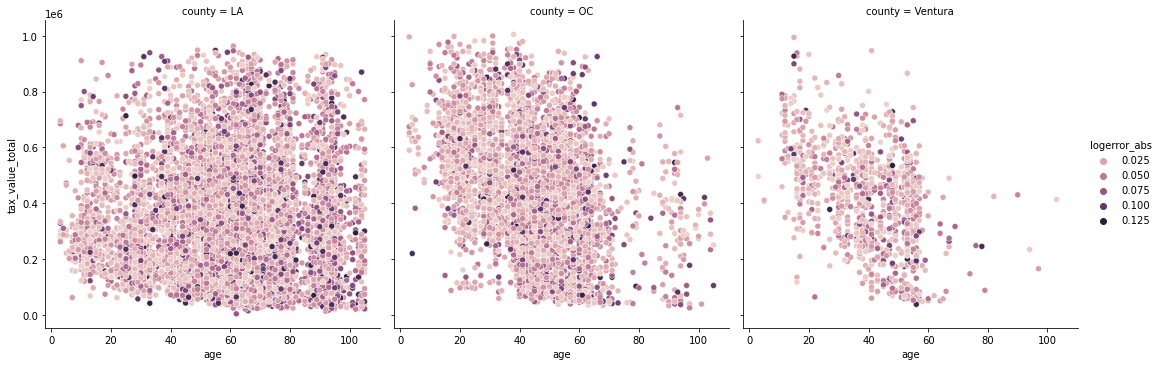

In [90]:
sns.relplot(data=X_train, x='age', y='tax_value_total', hue='logerror_abs', col='county', kind='scatter')

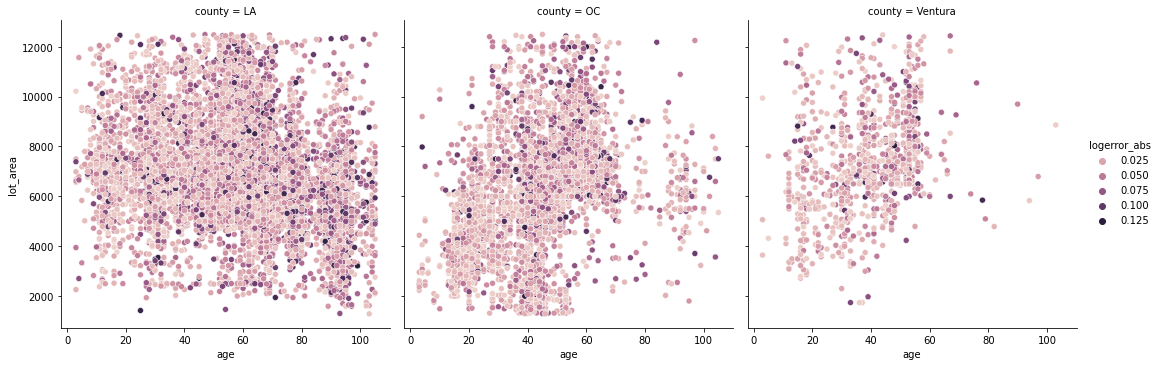

In [91]:
sns.relplot(data=X_train, x='age', y='lot_area', hue='logerror_abs', col='county', kind='scatter')

### Note:
- high log error cluster with high age and low house area
- high log error cluster with high age and low tax value
- hig log error cluster with high lot area and middle age

### Go Forward with Clustering:
- age
- house area
- lot area
- tax value

## Scale

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_train = train[['bathrooms',
                 'bedrooms',
                 'house_area',
                 'fips',
                 'latitude',
                 'longitude',
                 'lot_area',
                 'year_built',
                 'tax_value_total',
                 'logerror',
                 'age',
                 'logerror_abs',
                 'county'
]]

## Cluster

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
asdfasdfasdfasdfasdfasdfasdf

### Take Aways:
- ???K records

In [ ]:
df.isnull().sum()

### Take Aways:
- Too many nulls in neighborhood, pools, fireplace, garage
### What is the range of the transaction date? Found that 

In [ ]:
df.transactiondate.min(), df.transactiondate.max()

- Found that 2018 transactions exist
### What are the 2018 Transactions?

In [ ]:
df[df.transactiondate.str.contains('2018')]

- Found one record
### Remove record from df

In [ ]:
df = df.drop(index=52441)
df[df.transactiondate.str.contains('2018')]

- Confirmed 2018 record was remove

### Create Functions to Get Zillow Data

## <font color = 'red'> Clean Data

In [ ]:
df.head()

### Rename columns for Readability

In [ ]:
df.columns.to_list()

In [ ]:
# rename columns for readability
df = df.rename(columns = {'parcelid':'parcel_id',
                          'calculatedfinishedsquarefeet':'area',
                          'yearbuilt':'year_built',
                          'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms',
                          'taxvaluedollarcnt':'tax_value',
                          'taxamount':'tax_amount',
                          'transactiondate':'transaction_date',
                          'regionidzip':'zipcode',
                             'regionidneighborhood':'neighborhood',
                             'poolcnt':'pools',
                             'lotsizesquarefeet':'lot_size',
                          'garagecarcnt':'garages'
                         })

### Check Columns Names Changed

In [ ]:
df.columns

### Dropping transaction_date, and parcel_id columns since it doens't help with explore or modeling

In [ ]:
df = df.drop(columns=['transaction_date', 'parcel_id'])
df.columns

### Show describe without scientific notation

In [ ]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

### Take Away: 
- Huge Skew in tax value, area, lot_size
- Counts are off in multiple columns
- bedrooms and bathroom contain zero
### Change Blanks to Nulls

In [ ]:
# replace banks with NaN 
df = df.replace('', np.nan)

### Check for Nulls

In [ ]:
df.isnull().sum()

In [ ]:
value_cols = df.drop(columns=['area','year_built','tax_value','lot_size'])
for col in value_cols:
    print(f'----------------{col}--------------------')
    print(df[col].value_counts())

In [ ]:
df.isna().sum()

In [ ]:
df.shape

### Replaced Pool NaN with 0

In [ ]:
# replace pool, lot_size, l nan with 0
df.pools = df.pools.replace(np.nan, 0)

In [ ]:
df.pools.isna().sum()

In [ ]:
df.shape

### Replace lot_size with median, 6,384

In [ ]:
df[df.lot_size < 13000].lot_size.hist()

In [ ]:
# replace lot_size, lot_size, l nan with meian
df.lot_size = df.lot_size.replace(np.nan, df.lot_size.mean())
df.lot_size.isna().sum()

In [ ]:
df.shape

### Replace Zipcode NaN

In [ ]:
df.zipcode.describe()

In [ ]:
df[df.zipcode < 96995].zipcode.hist()

In [ ]:
df[(df.zipcode > 96600) & (df.zipcode < 97000)].zipcode.hist()

In [ ]:
df[(df.zipcode > 96206) & (df.zipcode < 96995)].zipcode.hist()

### Drop records with zipcode NaN, not useful 

### Replace year_built

In [ ]:
df.year_built.hist()

In [ ]:
df.year_built.describe()

In [ ]:
df.year_built.value_counts()

In [ ]:
#Set year_built to 1955, most used year
df.year_built = df.year_built.replace(np.nan, 1955)

In [ ]:
df.isna().sum()

### Replace area NaN with most used 

In [ ]:
df.area.describe()

In [ ]:
df.area.hist()

In [ ]:
df[df.area < 3000].area.hist()

In [ ]:
df[(df.area > 1268) & (df.area < 2306)].area.hist()

In [ ]:
df.area.value_counts()

### Replace Area NaN with Most Used 1120

In [ ]:
# replace area Nan with most used area (1120)
df.area = df.area.replace(np.nan, 1120)
df.isna().sum()

### Drop columns garage and neighborhood, too many missing NaN and not usefult

In [ ]:
# Drop garages and neighborhood, too many NaN in garage and neighborhoo
df = df.drop(columns=['garages','neighborhood'])
df.isna().sum()

### Drop Null from the rest beause recordes are few

In [ ]:
# NaN left are few, dropping all NaNs
df = df.dropna()
df.shape

### Nulls are removed
### Check Data Typ and change data type from float to int

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
# convert all columnst to integer for readability
df = df.astype('int')

### Confirm Data Type Changed to Integer for readabilityh

In [ ]:
df.info()

In [ ]:
df.head()

### Data Type changed to integer
## Visualizing Distributions and Outliers

### Plot Histograms

In [ ]:
plt.figure(figsize=(15, 5))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Aways
- x axis range is showing with no values meaning they are skewed
- tax_value has sever skew since its x-axis got to 1e7 
- area has skew

### Plot Box Plots

In [ ]:
# plot box plots for columns except fips
plt.figure(figsize=(15,8))
plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))
plt.show()

### Take Aways
- tax_value has a severe skew making the other columsn unreadable

### Visualize Columns with Larger Box Plots

In [ ]:
plt.figure(figsize=(15, 20))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Aways
- Lager Plot Boxesshow many outliers with a huge skew for tax_value

# <font color = 'red'>Prep Data (Tidy, Wrangle, Split)

## Tidy Data
### Remove Outliers

### Create List of columns to remove outliers from

In [ ]:
# prep for outlier removal: not including categories fips, pools, zipcode
cols_list = df.drop(columns=['fips','zipcode', 'pools'])
cols_list.head()

### Check Shape and Row Count

In [ ]:
df.shape

### Find quartile points for upper / lower bounds and remove outliers

In [ ]:
 for col in cols_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + 2 * iqr   # get upper bound
        lower_bound = q1 - 2 * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]


### Check shape and confirmed lost around 5K records

In [ ]:
df.shape

### Display Box Plots to visualize new ranges

In [ ]:
plt.figure(figsize=(15, 20))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Away:
- Box Plot outliers are more visual and boxes are clear
### Display historgrams to visualize distributions

In [ ]:
plt.figure(figsize=(15, 5))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Away:
- Distribution looks good, no more large blanks along the x-axis
- Tax_value x-axis has skew but I lowering the limit bounds doens't change
- Long/Lat has skew but I don't want to change the values
- End with 47.5K records

## Univariate Analysis

### Closer look at columns with histograph

In [ ]:

for col in df.columns:
    plt.figure(figsize=(15,5))
    plt.hist(df[col])
    plt.title(col)


In [ ]:
df.info()

In [ ]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

In [ ]:
# perform value counts for each column
for col in df.columns:
    print(f'----------------{col}--------------------')
    print(df[col].value_counts())

## Data Context
- 43.8K records
- lowest tax_value is 3.3K
- highest tax_value is 1.37M
- mean tax_value is about 343.2K
- most tax_value below 400K
- 
- bedroom counts: 2,3,4,5 (most have 3)
- bathroom counts: 1,2,3,4 (most have 2)
- most lot_size between 5K-7K sqft
- most house area between 1K and 1.75K sqft
- fips (county): 6037 (Los Angeles County),6059 (Orange County) , 6111 (Ventura County)
- most houses in fips6037
- most houses between latitude 33600000 and 34300000
- most houses between longitude -118600000 and -117600000

## Split Data

In [ ]:
 # train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [ ]:
df.shape, train.shape, validate.shape, test.shape

# <font color ='red'> Exploration and Pre-Processing

## Explore Train Data

### What are the questions:
- What are the transactions are in 2017?
    - Started with 52.5K houses, removed 5K for outliers/nulls, 47.5K houses remaining
- What states and counties are the properties located in?
    - California,. Counties: Los Angeles, Ventura, Orange
- What is the tax rate per county? (might have to combine columns to calcualate)
    - Los Angele County Tax Rate: 1.42%
    - Orange County Tax Rate: 1.21%
    - Vetura County Tax Rate: 1.18%
- What is the distribution of tax_value for each county?
    - LA County has the most houses with most of those peaking between 100-300K
    - Ventura and Orange County have less houses and peak between 300-500K
- What are the drivers of single family property values?
    - Drivers indicated: Area, Bathrooms, Bedrooms
- Why do some properties have a much higher value than others when they are located so close to each other?
    - ???
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
    - ???
- Is having 1 bathroom worse than having 2 bedrooms?
    - Bathroom seems to be more important than bedrooms

### What is the tax rate per county?

In [ ]:
((train[train.fips==6037].tax_amount) / (train[train.fips==6037].tax_value)).mean()

In [ ]:
((train[train.fips==6059].tax_amount) / (train[train.fips==6059].tax_value)).mean()

In [ ]:
((train[train.fips==6111].tax_amount) / (train[train.fips==6111].tax_value)).mean()

## Multivariate Analysis

### What are house values with pools

In [ ]:
sns.relplot(data=train, x='lot_size', y='tax_value', hue='pools')

### Note: 
- Pools increase with lot_size

### Show value by area with pools

In [ ]:
sns.relplot(data=train, x='area', y='tax_value', hue='pools')

### Slight correlationo with pools and house value

### Show house values by coorinates

In [ ]:
sns.relplot(data=train, x='longitude', y='latitude', hue='tax_value')
plt.show()

In [ ]:
train.tax_value.describe()

In [ ]:
# Show house vlaues create than mean by coorindates, shows a map
value_map = df[df.tax_value > df.tax_value.mean()]
sns.relplot(data=value_map, x='longitude', y='latitude', hue='tax_value', height=5, aspect=2)
plt.show()

In [ ]:
# Show relplot of long/lat coords to show map of homes valued at twice the mean
value_map = df[df.tax_value > (df.tax_value.mean() * 2)]
sns.relplot(data=value_map, x='longitude', y='latitude', hue='tax_value', height=5, aspect=2)
plt.show()

### Notes:
- Highest values alongm the coast and 

### What is the distribution of tax_value across counties
### Show Average Tax Amounts across Counties

In [ ]:
# Show Average House Tax Amounts Aross Counties
plt.figure(figsize=(15,5))
sns.barplot(x=train.fips, y=train.tax_amount)
plt.axhline(y=train.tax_amount.mean(), color='r')
plt.xlabel('County Identifer')
plt.ylabel('Average Tax Amount')
plt.show()

### Notes:
- Tax Amounts across counties don't have significant difference
### Shows Average Tax Value Across Counties

In [ ]:
# Show Average Tax Value across counties
plt.figure(figsize=(15,5))
sns.barplot(x=train.fips, y=train.tax_value)
plt.axhline(y=train.tax_value.mean(), color='red')
plt.xlabel('County Identifer')
plt.ylabel('Average Tax Value')
plt.show()

### Notes:
- No significant differnce of tax values between counties however 6037 does drop

### T-Test: Is avg tax_value in fips 6059 > avg tax_value in fips 6111
- H0: fips 6059 avg tax value <= fips 6111 avg tax_value
- H1: fips 6059 avg tax value > fips 6111 avg tax_value

In [ ]:
fips_6059 = train[train.fips==6059].tax_value
fips_6111 = train[train.fips==6111].tax_value

In [ ]:
alpha = .05
t,p = stats.ttest_ind(fips_6059, fips_6111)
t, p, alpha

### Notes:
- p < alpha, reject H0, fips 6059 is signficant increase

### T-Test: Is avg tax_value in fips 6059 > avg tax-value of all fips
- H0: fips 6059 avg tax value <= avg tax_value of all fips
- H1: fips 6059 avg tax value > avg tax_value of all fips

In [ ]:
fips_6059 = train[train.fips==6059].tax_value
fips_mean = train.tax_value.mean()

In [ ]:
alpha = .05
t,p = stats.ttest_1samp(fips_6059, fips_mean)
t, p, alpha

### Notes:
- p > alpha, reject H0, fips 6059 is greater than avg of tax_values across fips

### What is the distribution of Value for each Countya

In [ ]:
# Show distribution of House Values for each county
sns.displot(x=train.tax_value, hue=train.fips, height=5, aspect=2.5)
plt.xlabel('Home Tax Value')
plt.ylabel('Home Count')
plt.show()

### Note:
- In County 6037, More houses are around 100-300K
- In other counties, most house around 400K

### What is the tax amount distribution across counties?

### Note:
- county 6037, most around 3K
- other counties, most around 4-5K

### Use Pair Plot to find correlation

In [ ]:
#sns.pairplot(train)

### Notes:
- Nothing siginficant to show
### Show Heatmap to find correlation between columns

In [ ]:
corr_table = train.drop(columns=['fips']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_table, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(corr_table))
plt.show()

### Notes:
- tax_value:area = .50
- tax_value:bathrooms = .39
- tax_value:year_built = .25
- tax_value:bedrooms = .22
- area:bathrooms = .77
- area:bedrooms = .61
- area:year_built = .49
- bathroom:bedrooms = .58
- bathroom:year_built = .51
### Largest Correlations to Value is Area. Area to Bathrooms and Bedrooms.

### Show correlation between year_built and area with tax_value

In [ ]:
# Shows that value increases with area & year_built
sns.relplot(x='year_built', y='area', data=train,  hue='tax_value', kind='scatter')
plt.xlabel('Year Built')
plt.ylabel('House Tax Value')
plt.show()

### Notes:
- Show tax_value increases with area increase but year_built has little impact

### Show correlation between tax_value and area with bathrooms

In [ ]:
#shows that increasd area tends to have increases bathrooms. Slight correlation to increased value.
sns.relplot(x='area', y='tax_value', data=train, hue='bathrooms', kind='scatter')
plt.xlabel('House Area in Sqft')
plt.ylabel('House Tax Value')
plt.show()

### Notes:
- Shows that increased area has correlatioin with increased  bathroms but little impact to price

### Show correlation between area and tax_value with bedrooms

In [ ]:
# Shows that bedrooms does not associate to value. Mostly to area.
plt.figure(figsize=(10,10))
sns.relplot(x='area', y='tax_value', data=train, hue='bedrooms', kind='scatter')
plt.ylabel('House Tax Value')

### Notes:
- Show that bedrooms have slight correlatoin to area but not as much as bathroom. And little impact to value

### Show correlation between year_built and tax_value with bathrooms

In [ ]:
plt.figure(figsize=(10,10))
sns.relplot(x='year_built', y='tax_value', data=train, hue='bathrooms', kind='scatter')
plt.ylabel('House Tax Value')

### Notes:
- Show later years have more bathrooms which also have higher tax_value

### Show correlation between year_built and tax_value with bedrooms

In [ ]:
# Shows that later years have more bedrooms but seem to impact value
plt.figure(figsize=(10,20))
sns.relplot(x='year_built', y='tax_value', data=train, hue='bedrooms', kind='scatter')
plt.ylabel('House Tax Value')
plt.show()

### Notes:
- Slight correlation with inceasd bedrooms and new homes which increases value. Most likely because increased bedrooms means increased area.

### Show correlation between year_built and value with area

In [ ]:
# Shows increased area has  year increased and more high areas have high value
sns.relplot(x='year_built', y='tax_value', data=train, hue='area', kind='scatter')
plt.xlabel('Year Built')
plt.ylabel('House Tax Value')
plt.show()

### Notes:
- Shows increased area are newer homes and have high value

### Show correlation between year_built and value with fips

In [ ]:
# shows that 6037 has majority of properties, 6059 has more high value properties
sns.relplot(x='year_built', y='tax_value', data=train, hue='fips', kind='scatter')
plt.ylabel('House Tax Value')
plt.xlabel('Year Built')
plt.show()

### Notes:
- shows that 6037 has majority of properties
- show that 6059 abd 6111 has newer homes

### Show correlation between area and value with fips

In [ ]:
# compare area vs value by fips
sns.relplot(x='area', y='tax_value', data=train, hue='fips', kind='scatter')
plt.ylabel('House Tax Value')
plt.xlabel('House Area in Sqft')
plt.show()

### Notes:
- Shows area and value correlate across fips

### Plot Value to Lot Size by FIPS

In [ ]:
# compare lot size vs value by fips
sns.relplot(x='lot_size', y='tax_value', data=train, hue='fips', kind='scatter')
plt.ylabel('House Tax Value')
plt.xlabel('Lot Size in Sqft')
plt.show()

### Notes:
- 6059 has more smaller lots. Nothing significant toward value

### Show Bar Plot for value vs area by fips (Stopped Loading)

In [ ]:
# Bar plot ford value vs area categoriezed by fips.
# sns.barplot(data=train, y='tax_value', x='area')
# plt.ylabel('House Tax Value')
# plt.show()

### Note:
- Show nothing new. value increases with area.

### Show Strip Plot

In [ ]:
# sns.stripplot(x='bedrooms', y='tax_value', data=atrain)

### Note:
- Stip Plot shows nothging readable

## Summarize Exploration
- We have 47,500 houses across three California counites of (Los Angeles, Ventura, and Orange)
- Best Three drivers are Area, Bathrooms, and Bedrooms in that order
- Los Angels County has a .2% higher tax rate than the other counties. It also had significantly more houses with a value distribution that peaks between 100-300K.
- Ventura and Orange Counties have a lower tax rate and with significantly less houses that have a value distribution that peak between 300-500K.
- More high value hosues are along the coast and in Orange County

## Pre-Processing (Prep Data for Modeling)

### Drop Unusable and Unneeded Columns for Modeling

In [ ]:
# Drop columns not needed
train = train.drop(columns=['tax_amount'])
validate = validate.drop(columns=['tax_amount'])
test = test.drop(columns=['tax_amount'])
train.head()

### Note:
- Dropped tax_amount since it wil be data leakage during modeling

# <font color = 'red'>Experiment with Models

In [ ]:
# Filter sets by fips
train = train[train.fips==6111]
validate = train[train.fips==6111]
test = train[train.fips==6111]

## Results:
- ???

### Create y_train and X_train sets

In [ ]:
# establish target column
target = 'tax_value'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train.drop(columns=[target])
y_train = train[target]

X_validate = validate.drop(columns=[target])
y_validate = validate[target]

X_test = test.drop(columns=[target])
y_test = test[target]

In [ ]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

### Scale

In [ ]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [ ]:
X_train_scaled.head()

### Feature Engineering

### Use Select K Best to find 3 Best Features


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Use f_regression stats test each column to find best 3 features
f_selector = SelectKBest(f_regression, k=3)

# find tthe best correlations with y
f_selector.fit(X_train_scaled, y_train)

# Creaet boolean mask of the selected columns. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

### Note:
- Select K Best selected area, year_built, and bathrooms.

### Use Recursive Feature Elemination to select 3 best features

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create the ML algorithm container
lm = LinearRegression()

# create the rfe container with the the number of features I want. 
rfe = RFE(lm, n_features_to_select=3)

# fit RFE to the data
rfe.fit(X_train_scaled,y_train)  

# get the mask of the selected columns
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

### Notes:
- RFE Select 3 Best Columns: area, latitude, longitude



In [ ]:
X_train_scaled.head()

In [ ]:
# Remove Features before Modeling
# X_train_scaled = X_train_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])
# X_validate_scaled = X_validate_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])
# X_test_scaled = X_test_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])

# <font color = 'red'>Modeling

## Create Baseline & Evaluate with RMSE

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head()

In [ ]:
# Add target mean column as baseline check
y_train['mean_pred'] = y_train.tax_value.mean()
y_validate['mean_pred'] = y_validate.tax_value.mean()

# add target median column as baseline check
y_train['median_pred'] = y_train.tax_value.median()
y_validate['median_pred'] = y_validate.tax_value.median()

In [ ]:
# Create Baseline RMSE of target mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.mean_pred) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.mean_pred) ** .5

In [ ]:
# Show RMSE Score for train and validate
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
# Create Baseline RMSE of target median
rmse_train = mean_squared_error(y_train.tax_value, y_train.median_pred) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.median_pred) ** .5

In [ ]:
# Show RMSE Score for train and validate
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

### Notes:
- Mean Baseline RMSE (258K) is better than Median Baseline RMSE (261K)

### Create Metric Holder

In [ ]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [ ]:
metric_df

## Develop Models 

### Create Model 1 - Linear Regression (OLS) 

In [ ]:
# create, fit, predict ols model
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.tax_value)
y_train['ols_pred'] = ols.predict(X_train_scaled)

In [ ]:
ols.coef_

In [ ]:
# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.ols_pred) ** .5

# predict validate
y_validate['ols_pred'] = ols.predict(X_validate_scaled)

# evaluate rmse of train and validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.ols_pred) ** .5

In [ ]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- RMSE of OLS is better than baseline by 44K

### Create Model 2: Lassolars with Alpha = .01

In [ ]:
# create object of model
lars = LassoLars(alpha=0.01)

# fit object to train data. Specify y_train column since it converted to a dataframe
lars.fit(X_train_scaled, y_train.tax_value)

# predict on train
y_train['lars_pred'] = lars.predict(X_train_scaled)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lars_pred) ** .5

# predict validate
y_validate['lars_pred'] = lars.predict(X_validate_scaled)

# create rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lars_pred) ** .5

In [ ]:
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

In [ ]:
lars.coef_

In [ ]:
metric_df = metric_df.append({
    'model': 'lasso_alpha_.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Lassolars RMSE is the same as OLS

### Create Model 3: TweedieRegressor (GLM) General Linear Model with Power  = 1 (Poisson) and Alpha=.01

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=.01)


# fit the model train data. Specify y_train columns since it was converted to dataframe 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['glm_pred'] = glm.predict(X_train_scaled)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.glm_pred) ** .5

# predict validate
y_validate['glm_pred'] = glm.predict(X_validate_scaled)

# evaluate train and validate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm_pred) ** .5

print("RMSE for GLM using Tweedie, power=1 & alpha=.01\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# added to metric holder
metric_df = metric_df.append({
    'model': 'glm_poisson_.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- glm rmse is the same as ols and lassolars

### Create Model 4 - Polynomial Regression

In [ ]:
# create polynomial features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled to new sets
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

In [ ]:
# create the model object
lm2 = LinearRegression()

# fit the model train data. Specify y_train columns since it was converted to dataframe  
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['lm2_pred'] = lm2.predict(X_train_degree2)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm2_pred) ** .5

# predict validate
y_validate['lm2_pred'] = lm2.predict(X_validate_degree2)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm2_pred) ** .5

In [ ]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# add to metric holder
metric_df = metric_df.append({
    'model': 'PolynomialRegressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Polynomial Regression RMSE is better than ols and lassolars by 8K

### Create Model 5 - New LassoLars with Alpha .0001
- I changed alpha to .01 and RMSE didn't change

In [ ]:
# create object of model
lars = LassoLars(alpha=0.0001)

# fit object to train data. Specify y_train column since it converted to a dataframe
lars.fit(X_train_scaled, y_train.tax_value)

# predict on train
y_train['lars_pred_.0001'] = lars.predict(X_train_scaled)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train['lars_pred_.0001']) ** .5

# predict validate
y_validate['lars_pred_.0001'] = lars.predict(X_validate_scaled)

# create rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate['lars_pred_.0001']) ** .5

print("RMSE for Lasso + Lars, alpha=.0001\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

# add to metric holder
metric_df = metric_df.append({
    'model': 'LassoLars_.0001', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

# Notes:
- Still Around 230K

### Create Model 6 - TweedieRegressor with Alpha = .0001 and Power = 1 (Poisson)

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=.0001)


# fit the model train data. Specify y_train columns since it was converted to dataframe 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['glm_pred_.0001'] = glm.predict(X_train_scaled)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train['glm_pred_.0001']) ** .5

# predict validate
y_validate['glm_pred_.0001'] = glm.predict(X_validate_scaled)

# evaluate train and validate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate['glm_pred_.0001']) ** .5

print("RMSE for GLM using Tweedie, power=1 & alpha=.0001\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

# add to metric holder
metric_df = metric_df.append({
    'model': 'glm_poisson_.0001', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Polynomial Regression performs the best at 209K, around 8K better
- I experimented with reducing features: removed fips, then removed year_built with only change to Polynomial Regressor bringing it closer to others.Finally added features: lot_size, lat/long, pools.
- GLM scored the worst at 266K, cose to baseline 270K, DO NOT USE (first iteration)
- (2nd Run) All except PolyReg was the same scored at 217K
- OLS and LassoLars scored around 230K (first run)

## <font color = 'red' > Evaluate
    
### Plotting Actual vs Predicted Values

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.mean_pred, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=20)

plt.scatter(y_validate.tax_value, y_validate.ols_pred, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ????

### Residual Plots: Plotting the Errors in Predictions

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.ols_pred - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
# plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ???

### Histograms of Actuals vs Predicted Values

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.ols_pred, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.glm_pred, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.lm2_pred, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Values")
plt.ylabel("Number of Homes ")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

### Notes:
- Models capture most of actual values distribution but miss the lower valued homes

## Model Selection and Out-of-Sample Evaluatoin

In [ ]:
# predict train
y_test['lm2_pred'] = lm2.predict(X_test_degree2)

# create rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.lm2_pred) ** .5

print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample: ", rmse_test)# add to metric holder

In [ ]:
metric_df

### Notes:
- Polynomial Model RMSE is 18.6M indicating wrong model to use and/or overfit

### Check with OLS

In [ ]:
# predict test
y_test['ols_pred'] = ols.predict(X_test_scaled)

# evaluate rmse of train and validate
rmse_test = mean_squared_error(y_test.tax_value, y_test.ols_pred) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_test)

### Note:
- OLS performed worse than baseline on test data set

# <font color = 'red'> Conclusion

## Summary
- 

## Recommendations
- ???

## Conclusion
- ???

### Project Description

- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each count

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebooks
    - Acquire and Prepare Modules
    - Misc Artifacts
1. Regression Model (Linear or Non-Linear)
2. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
3. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

## Live Presentation

- intro (live)
- audience & setting  (live)
- content (live)
- Verbal Conclusion (findings, next steps, recommendations)  (live) 
- time (live) 

## Deliver Predictions
- Deliver predictions (.csv) 